# Modelling notebook

# Table of contents
1. [Importing the file and libraries](#1)
2. [Defining function](#forgotten)
3. [Pre-processing](#3)
    1. [Data preparation](#3.1)
    2. [Standardization](#3.2)
    3. [Elastic Net Regression](#3.3)
    4. [Setting up final dataframe](#3.4)
4. [Initial modelling](#4)
5. [Fine-tuning](#5)
    1. [Evaluation 1 - random fluctuations](#5.1)
    2. [Evaluation 2 - simple fluctuations](#5.2)
    3. [Evaluation 3 - fluctuations with scale](#5.3)
6. [Final model](#6)
7. [Sensitivity analysis](#7)

This notebook represents the modelling step of the research design. This includes the data preparation steps, and scenario generation combining MCS with multiple regression. Next a formula calculating the market attractiveness index is used to finally estimate the market size of the microplastic filters in California for the next 10 years for the various scenarios generated. Finalizing with a sensitivity analysis.

# Importing the file and libraries <a name="1"></a>

In [1]:
%%capture
!pip install geopandas
!pip install SALib

In [2]:
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import matplotlib.colors as colors
import warnings
import plotly.graph_objects as go
import geopandas as gpd
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, davies_bouldin_score, mean_absolute_percentage_error, silhouette_score
from sklearn.cluster import KMeans
from sklearn.datasets import make_regression
from statsmodels.tsa.arima_process import ArmaProcess
from scipy.spatial.distance import cdist
from numpy.random import default_rng
from SALib.sample import saltelli
from SALib.analyze import sobol
from scipy.stats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor

InteractiveShell.ast_node_interactivity = "all"
%autosave 120

Autosaving every 120 seconds


In [3]:
df_final=pd.read_csv('/project/df_final.csv')

# Defining function <a name="forgotten"></a>

In [4]:
def silhouette_elbow(scenario_dataframe):
    '''Function to show both the silhouette score and elbow method for the scenarios generated dataframe to define optimal k'''
    max_clusters = 20
    silhouette_scores = []
    wcss = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=1509)
        kmeans.fit(scenario_dataframe)

        # Compute the silhouette score
        silhouette_avg = silhouette_score(scenario_dataframe, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

        # Compute the within-cluster sum of squares (WCSS)
        wcss.append(kmeans.inertia_)

    # Plot silhouette scores
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('Silhouette Score for Optimal k')

    # Plot WCSS
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), wcss, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WCSS')
    plt.title('WCSS for Optimal k')

    plt.tight_layout()
    plt.show();

In [5]:
def kmeans(scenarios_generated_transformed, scenarios_generated, clusters):
    '''Function to initialize kmeans clustering, with input of the dataframe of the scenarios generated transformed dataframe, scenarios generated non transformed dataframe and number of clusters'''
    # Initialize KMeans
    kmeans = KMeans(n_clusters=clusters, random_state=1509) 

    # Fit KMeans on the transposed scenarios
    kmeans.fit(scenarios_generated_transformed)

    # Get the cluster centers and transpose them back to original form
    representative_scenarios = kmeans.cluster_centers_.T

    # Find the closest points in the original data to each of the cluster centers
    closest_scenarios = np.argmin(cdist(scenarios_generated_transformed, kmeans.cluster_centers_), axis=0)

    # Use the indices of these closest scenarios to obtain their corresponding scenario labels from the original DataFrame
    representative_scenarios_labels = scenarios_generated_transformed.index[closest_scenarios]

    # Convert the cluster centers into a DataFrame and assign the corresponding scenario labels
    representative_scenarios_df = pd.DataFrame(representative_scenarios, columns=representative_scenarios_labels, index=scenarios_generated.index)
    return representative_scenarios_df

In [6]:
def plot_historic_future_scenarios(selected_scenarios):
    '''Function to plot the historic washing machine data and the selected scenarios for the future years'''
    # Plot historical target variable
    df_y.plot(kind='line', color='black', label='Historical Data')

    # Append the last point of historical data to the beginning of each scenario
    last_historical_point = df_y.iloc[-1]

    representative_scenarios_df_updated = pd.concat([pd.DataFrame({col: [last_historical_point] for col in selected_scenarios.columns},
                                                                  index=[df_y.index[-1]]),
                                                     selected_scenarios])
    # Plot future scenarios
    for column in representative_scenarios_df_updated.columns:
        representative_scenarios_df_updated[column].plot(kind='line', label=column)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Historical and Future Scenarios of Target Variable')
    plt.xlabel('Year')
    plt.ylabel('Revenue_California_Billion_USD')
    plt.show();

In [7]:
def independent_var_comparison(scenarios_selected, independent_var_df):
    # Determine the number of rows and columns for the subplots
    num_columns = 2  
    num_rows = (len(X_selected_filtered.columns) + num_columns - 1) // num_columns

    # Create the subplots
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(12, 18))
    axs = axs.flatten()  # Flatten the axes array for easier iteration
    X_selected_mean = X_selected.groupby(X_selected.index).mean()

    # Iterate over each column in X_selected
    for i, column in enumerate(X_selected_filtered.columns):
        ax = axs[i]  
        
        # Retrieve the values for the current column
        column_values = independent_var_df[column]

        # Plot actual values in X_selected for the same date range
        actual_values = X_selected_mean.loc[scenarios_selected.index, column]
        ax.plot(scenarios_selected.index, actual_values, label='Actual', color='black', linestyle='dotted')

        # Iterate over each scenario in representative_scenarios_df
        for scenario in scenarios_selected.columns:
            # Retrieve the values for the current scenario
            values = column_values[scenario]
            ax.plot(scenarios_selected.index, values, label=scenario)

            # Calculate and plot the trend line
            trend_line = np.polyfit(range(len(values)), values, 1)
            trend_values = np.polyval(trend_line, range(len(values)))
            ax.plot(scenarios_selected.index, trend_values, linestyle='--', color=ax.lines[-1].get_color())

        # Customize the subplot
        ax.set_xlabel('Time')
        ax.set_ylabel(column)
        ax.set_title(f'Evolution of {column} - \nComparing actual vs. generated')

    # Remove empty subplots
    for ax in axs[len(X_selected_filtered.columns):]:
        fig.delaxes(ax)
        
    # Add a common legend 
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(scenarios_selected.columns) + 1)

    fig.tight_layout()
    plt.show();

In [8]:
def independent_var_generated(selected_scenarios, independent_var_df):
    '''Function to plot the independent variables generated with MCS for each selected scenario'''
    # Determine the number of rows and columns for the subplots
    num_columns = 2  
    num_rows = (len(X_selected.columns) + num_columns - 1) // num_columns

    # Create the subplots
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(12, 18))
    axs = axs.flatten()  

    # Iterate over each column in X_selected
    for i, column in enumerate(X_selected.columns):
        ax = axs[i]  

        # Retrieve the values for the current column
        column_values = independent_var_df[column]

        # Iterate over each scenario in representative_scenarios_df
        for scenario in selected_scenarios.columns:
            # Retrieve the values for the current scenario
            values = column_values[scenario]
            ax.plot(selected_scenarios.index, values, label=scenario)

            # Calculate the trend line using numpy's polyfit
            trend_line = np.polyfit(range(len(values)), values, 1)
            trend_values = np.polyval(trend_line, range(len(values)))
            ax.plot(selected_scenarios.index, trend_values, linestyle='--', color=ax.lines[-1].get_color())

        # Customize the subplot
        ax.set_xlabel('Time')
        ax.set_ylabel(column)
        ax.set_title(f'Evolution of {column} \nin the independent variables generated')
        
    # Remove empty subplots
    for ax in axs[len(X_selected.columns):]:
        fig.delaxes(ax)

    # Add a common legend to the subplots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(selected_scenarios.columns))

    fig.tight_layout()
    plt.show();

In [9]:
def compare_actual_generated(selected_scenarios):
    # Plot historical target variable
    df_y.plot(kind='line', color='black', label='Historical Data')

    # Plot future scenarios
    for column in selected_scenarios.columns:
        selected_scenarios[column].plot(kind='line', label=column)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Historical and Future Scenarios of Target Variable')
    plt.xlabel('Year')
    plt.ylabel('Revenue_California_Billion_USD')
    plt.show();

# Pre-processing <a name="3"></a>

## Data preparation <a name="3.1"></a>

In [10]:
df_final.drop(columns=['Region','GeoName','Average_Precipitation_per_Year','Average_PDSI_per_Year','Volume_California_Million_Pieces'],inplace=True)

In [11]:
df_final['Year'] = pd.to_datetime(df_final['Year'], format='%Y')

df_final.set_index('Year', inplace=True)

the datetime index in python always must include day, month and year. So we will take the minimum value of each year, being 01.01.YEAR. However, it is important to note that all the data of a year represents the whole year, and not that one day of the year. 

In [12]:
df_final

,Total_population,Total_households,Female_population,Male_population,Median_age,Median_household_income_past_12m,Bachelor_degree,Master_degree,Professional_degree,Doctorate_degree,...,personalOppose,regulate,regulateOppose,timing,timingOppose,worried,worriedOppose,Average_Temperature_per_Year,Price_per_unit_thousands_USD,Revenue_California_Billion_USD
Year,,,,,,,,,,,,,,,,,,,,,
2014-01-01,64209,26771,31910,32299,45.2,35997,4935.0,1745.0,420.0,344.0,...,53.00,78.00,21.00,43.00,56.00,57.00,43.00,61.45,0.52825,0.680058
2014-01-01,9335,3893,4608,4727,47.1,38560,955.0,144.0,95.0,59.0,...,54.00,74.00,26.00,42.00,56.00,55.00,44.00,61.45,0.52825,0.680058
2014-01-01,18439,7891,9171,9268,45.3,45625,1800.0,730.0,190.0,115.0,...,53.00,77.00,23.00,43.00,56.00,57.00,42.00,61.45,0.52825,0.680058
2014-01-01,431555,142028,215185,216370,33.6,63409,49596.0,21078.0,6943.0,5951.0,...,48.00,77.00,21.00,48.00,50.00,62.00,37.00,61.45,0.52825,0.680058
2014-01-01,177026,46952,86290,90736,31.9,41772,9993.0,3361.0,718.0,132.0,...,40.00,76.00,22.00,46.00,53.00,62.00,38.00,61.45,0.52825,0.680058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-01,470999,139631,234574,236425,31.3,57394,28347.0,10735.0,2472.0,778.0,...,38.96,69.05,28.61,59.14,40.86,67.42,32.44,60.35,0.47700,0.748181
2021-01-01,55243,23103,26488,28755,48.6,66846,6817.0,2441.0,768.0,370.0,...,51.00,68.34,30.35,52.33,47.67,56.83,43.12,60.35,0.47700,0.748181
2021-01-01,845255,274471,424655,420600,38.7,94150,124047.0,48602.0,13872.0,9090.0,...,43.52,73.48,25.07,60.09,39.91,68.20,31.81,60.35,0.47700,0.748181


In [13]:
df_final['Higher_degree']=df_final['Bachelor_degree']+df_final['Master_degree']+df_final['Professional_degree']+df_final['Doctorate_degree']
df_final.drop(columns=['Bachelor_degree', 'Master_degree', 'Professional_degree',
       'Doctorate_degree'],inplace=True)

In [14]:
df_final

,Total_population,Total_households,Female_population,Male_population,Median_age,Median_household_income_past_12m,Num_employed,Num_unemployed,Labor_force,Avg_household_size,...,regulate,regulateOppose,timing,timingOppose,worried,worriedOppose,Average_Temperature_per_Year,Price_per_unit_thousands_USD,Revenue_California_Billion_USD,Higher_degree
Year,,,,,,,,,,,,,,,,,,,,,
2014-01-01,64209,26771,31910,32299,45.2,35997,22288,4452,26740,2.36,...,78.00,21.00,43.00,56.00,57.00,43.00,61.45,0.52825,0.680058,7444.0
2014-01-01,9335,3893,4608,4727,47.1,38560,3517,495,4012,2.25,...,74.00,26.00,42.00,56.00,55.00,44.00,61.45,0.52825,0.680058,1253.0
2014-01-01,18439,7891,9171,9268,45.3,45625,8336,713,9049,2.27,...,77.00,23.00,43.00,56.00,57.00,42.00,61.45,0.52825,0.680058,2835.0
2014-01-01,431555,142028,215185,216370,33.6,63409,198675,19444,218119,2.91,...,77.00,21.00,48.00,50.00,62.00,37.00,61.45,0.52825,0.680058,83568.0
2014-01-01,177026,46952,86290,90736,31.9,41772,57838,12765,70603,3.55,...,76.00,22.00,46.00,53.00,62.00,38.00,61.45,0.52825,0.680058,14204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-01,470999,139631,234574,236425,31.3,57394,187269,21293,208562,3.33,...,69.05,28.61,59.14,40.86,67.42,32.44,60.35,0.47700,0.748181,42332.0
2021-01-01,55243,23103,26488,28755,48.6,66846,21541,1896,23437,2.24,...,68.34,30.35,52.33,47.67,56.83,43.12,60.35,0.47700,0.748181,10396.0
2021-01-01,845255,274471,424655,420600,38.7,94150,410141,24236,434377,3.03,...,73.48,25.07,60.09,39.91,68.20,31.81,60.35,0.47700,0.748181,195611.0


While we have checked the 4 assumptions of multiple regression in another notebook, we have to check for multicollinearity as well. This can be done with the VIF score for each predictor variable, and solved with Elastic Net Regression feature selection. 

In [15]:
# Compute VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = df_final.columns
vif["VIF"] = [variance_inflation_factor(df_final.values, i) for i in range(df_final.shape[1])]

# Display VIF values
print("\nVariance Inflation Factor (VIF):")
print(vif)


Variance Inflation Factor (VIF):
                                    Variable           VIF
0                           Total_population           inf
1                           Total_households  8.789931e+03
2                          Female_population           inf
3                            Male_population           inf
4                                 Median_age  1.510590e+02
5           Median_household_income_past_12m  2.165684e+02
6                               Num_employed           inf
7                             Num_unemployed           inf
8                                Labor_force           inf
9                         Avg_household_size  3.544528e+02
10       Median_value_owner_occupied_housing  1.159040e+02
11              Households_solar_energy_fuel  1.026313e+01
12                              Num_under_18           inf
13                              Num_18_to_34           inf
14                              Num_35_to_64           inf
15                    

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


For the infinity related vatriables, we will only keep the 18 to 35 and the female population becasue these are more related to buying green products accoridng to our anlaysis of key factors. similarly, we will keep the number of employed people

In [16]:
df_final.drop(columns=['Num_under_18','Num_35_to_64','Num_65_more','Num_unemployed','Male_population'],inplace=True)


In [17]:
# Select all variables except the target variable
predictors = df_final.drop('Revenue_California_Billion_USD', axis=1)

# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data['Variable'] = predictors.columns
vif_data['VIF'] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

# Print the VIF results
print(vif_data)

                                    Variable           VIF
0                           Total_population  65786.543869
1                           Total_households   5000.029685
2                          Female_population  79504.391547
3                                 Median_age    149.618527
4           Median_household_income_past_12m    196.738844
5                               Num_employed   8740.529162
6                                Labor_force  20794.557134
7                         Avg_household_size    349.506076
8        Median_value_owner_occupied_housing    105.939665
9               Households_solar_energy_fuel      8.707384
10                              Num_18_to_34   1891.715730
11  Num_industry_agriculture_fishing_hunting      4.304897
12                                 consensus   2681.858850
13                           consensusOppose   2671.003455
14                                 futuregen  28090.832142
15                           futuregenOppose   2591.5141

All the consensus and consensusOppose etc... are obviously highly correlated. while consensus != 1 - consensusOppose because some people refused to answer, that percentage is small (back it up with graphs). Thus, instead we will replace these variables with ratios that represent the ratio between the people that believe and oppose the belief.  

In [18]:
# Create ratio variables
df_final['futuregen_ratio'] = df_final['futuregen'] / df_final['futuregenOppose']
df_final['consensus_ratio'] = df_final['consensus'] / df_final['consensusOppose']
df_final['happening_ratio'] = df_final['happening'] /df_final['happeningOppose']
df_final['harmUS_ratio'] = df_final['harmUS'] / df_final['harmUSOppose']
df_final['human_ratio'] = df_final['human'] / df_final['humanOppose']
df_final['personal_ratio'] = df_final['personal'] / df_final['personalOppose']
df_final['regulate_ratio'] = df_final['regulate'] / df_final['regulateOppose']
df_final['timing_ratio'] = df_final['timing'] / df_final['timingOppose']
df_final['worried_ratio'] = df_final['worried'] / df_final['worriedOppose']


In [19]:
df_final.drop(columns=['futuregen','futuregenOppose','consensus','consensusOppose',
                    'happening','happeningOppose','harmUS','harmUSOppose','human','humanOppose',
                       'personal','personalOppose','regulate','regulateOppose',
                       'timing','timingOppose','worried','worriedOppose']
    # all the values transformed in ratios
                  ,inplace=True)

## Standardization <a name="3.2"></a>

In [20]:
# Extract the index
index = df_final.index

df_X = df_final.drop('Revenue_California_Billion_USD', axis=1) 
df_y = df_final['Revenue_California_Billion_USD']

# Create a separate scaler object for X and y
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Standardize X and y
df_X_scaled = pd.DataFrame(scaler_X.fit_transform(df_X), columns=df_X.columns)
df_y_scaled = pd.DataFrame(scaler_y.fit_transform(df_y.values.reshape(-1,1)), columns=['Revenue_California_Billion_USD'])

# Restore the index
df_X_scaled.index = index
df_y_scaled.index = index

In [21]:
df_final['Revenue_California_Billion_USD']

Year
2014-01-01    0.680058
2014-01-01    0.680058
2014-01-01    0.680058
2014-01-01    0.680058
2014-01-01    0.680058
                ...   
2021-01-01    0.748181
2021-01-01    0.748181
2021-01-01    0.748181
2021-01-01    0.748181
2021-01-01    0.748181
Name: Revenue_California_Billion_USD, Length: 464, dtype: float64

Review VIF

In [22]:
# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_X_scaled,df_y_scaled, test_size=0.2, random_state=13)

In [23]:
# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data['Variable'] = df_X_scaled.columns
vif_data['VIF'] = [variance_inflation_factor(df_X_scaled.values, i) for i in range(df_X_scaled.shape[1])]

print(vif_data)

                                    Variable           VIF
0                           Total_population  53110.340285
1                           Total_households   3029.792480
2                          Female_population  64474.912424
3                                 Median_age      3.232545
4           Median_household_income_past_12m     14.682102
5                               Num_employed   6111.407691
6                                Labor_force  15429.600641
7                         Avg_household_size      5.752897
8        Median_value_owner_occupied_housing     25.784522
9               Households_solar_energy_fuel      6.232014
10                              Num_18_to_34   1472.375077
11  Num_industry_agriculture_fishing_hunting      2.575635
12              Average_Temperature_per_Year      3.544128
13              Price_per_unit_thousands_USD     10.231234
14                             Higher_degree    394.564983
15                           futuregen_ratio     34.6717

In [24]:
# check how many variables have a correlation above 70%
corr_matrix = df_X_scaled.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
high_corr = [column for column in upper.columns if any(upper[column] > 0.70)]
len(high_corr)

/tmp/ipykernel_261/2495392986.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


18

In [25]:
high_corr

['Total_households',
 'Female_population',
 'Num_employed',
 'Labor_force',
 'Avg_household_size',
 'Median_value_owner_occupied_housing',
 'Num_18_to_34',
 'Price_per_unit_thousands_USD',
 'Higher_degree',
 'futuregen_ratio',
 'consensus_ratio',
 'happening_ratio',
 'harmUS_ratio',
 'human_ratio',
 'personal_ratio',
 'regulate_ratio',
 'timing_ratio',
 'worried_ratio']

## Elastic Net Regression <a name="3.3"></a>

In [26]:
# Define the hyperparameter search space for grid search
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0],
    'max_iter': [100, 500, 1000],
    'tol': [0.0001, 0.001, 0.01]
}

In [27]:
%%capture
# Create ElasticNet model
elastic_net = ElasticNet()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model performance
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Fit the best model to the data
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [28]:
# Print the best hyperparameters
print("Best hyperparameters:", best_params)

Best hyperparameters: {'alpha': 0.01, 'l1_ratio': 0.75, 'max_iter': 500, 'tol': 0.0001}


In [29]:
# X.columns because this allows us to extract the column names from the unscaled data
important_features = pd.DataFrame(index=df_X_scaled.columns, data=best_model.coef_, columns=["coefs"]) 
selected_features = important_features[important_features['coefs'] != 0].index

# Convert selected_features to a list
selected_features_list_cv5 = list(selected_features)

In [30]:
selected_features_list_cv5

['Female_population',
 'Median_age',
 'Num_industry_agriculture_fishing_hunting',
 'Average_Temperature_per_Year',
 'Price_per_unit_thousands_USD',
 'happening_ratio',
 'harmUS_ratio',
 'regulate_ratio',
 'timing_ratio',
 'worried_ratio']

In [31]:
vif = pd.DataFrame()
vif["Feature"] = selected_features_list_cv5
vif["VIF"] = [variance_inflation_factor(df_X_scaled[selected_features_list_cv5].values, i) for i in range(len(selected_features_list_cv5))]

print(vif)

                                    Feature        VIF
0                         Female_population   1.300915
1                                Median_age   2.020373
2  Num_industry_agriculture_fishing_hunting   1.625397
3              Average_Temperature_per_Year   3.329895
4              Price_per_unit_thousands_USD   7.305469
5                           happening_ratio  13.040527
6                              harmUS_ratio  22.150391
7                            regulate_ratio   5.313516
8                              timing_ratio  17.355221
9                             worried_ratio  27.988022


In [32]:
df_X.columns

Index(['Total_population', 'Total_households', 'Female_population',
       'Median_age', 'Median_household_income_past_12m', 'Num_employed',
       'Labor_force', 'Avg_household_size',
       'Median_value_owner_occupied_housing', 'Households_solar_energy_fuel',
       'Num_18_to_34', 'Num_industry_agriculture_fishing_hunting',
       'Average_Temperature_per_Year', 'Price_per_unit_thousands_USD',
       'Higher_degree', 'futuregen_ratio', 'consensus_ratio',
       'happening_ratio', 'harmUS_ratio', 'human_ratio', 'personal_ratio',
       'regulate_ratio', 'timing_ratio', 'worried_ratio'],
      dtype='object')

In [33]:
selected_features_list_cv5 = selected_features_list_cv5 + ['Median_household_income_past_12m','Households_solar_energy_fuel','Higher_degree']

In [34]:
vif = pd.DataFrame()
vif["Feature"] = selected_features_list_cv5
vif["VIF"] = [variance_inflation_factor(df_X_scaled[selected_features_list_cv5].values, i) for i in range(len(selected_features_list_cv5))]

print(vif)

                                     Feature        VIF
0                          Female_population  42.460875
1                                 Median_age   2.084704
2   Num_industry_agriculture_fishing_hunting   1.910250
3               Average_Temperature_per_Year   3.348461
4               Price_per_unit_thousands_USD   7.657071
5                            happening_ratio  14.672261
6                               harmUS_ratio  24.893585
7                             regulate_ratio   6.263536
8                               timing_ratio  19.660096
9                              worried_ratio  30.487448
10          Median_household_income_past_12m   2.867124
11              Households_solar_energy_fuel   2.636549
12                             Higher_degree  46.782631


In [35]:
selected_features_list_cv5.remove('Female_population')
selected_features_list_cv5.remove('worried_ratio')

In [36]:
# Create a list of all features
features_to_use = selected_features_list_cv5
# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = features_to_use
vif["VIF"] = [variance_inflation_factor(df_X_scaled[features_to_use].values, i) for i in range(len(features_to_use))]

print(vif)

                                     Feature        VIF
0                                 Median_age   2.042454
1   Num_industry_agriculture_fishing_hunting   1.631931
2               Average_Temperature_per_Year   3.261353
3               Price_per_unit_thousands_USD   7.385138
4                            happening_ratio  11.659086
5                               harmUS_ratio  18.385153
6                             regulate_ratio   4.659533
7                               timing_ratio  17.580942
8           Median_household_income_past_12m   2.278090
9               Households_solar_energy_fuel   2.552280
10                             Higher_degree   2.546573


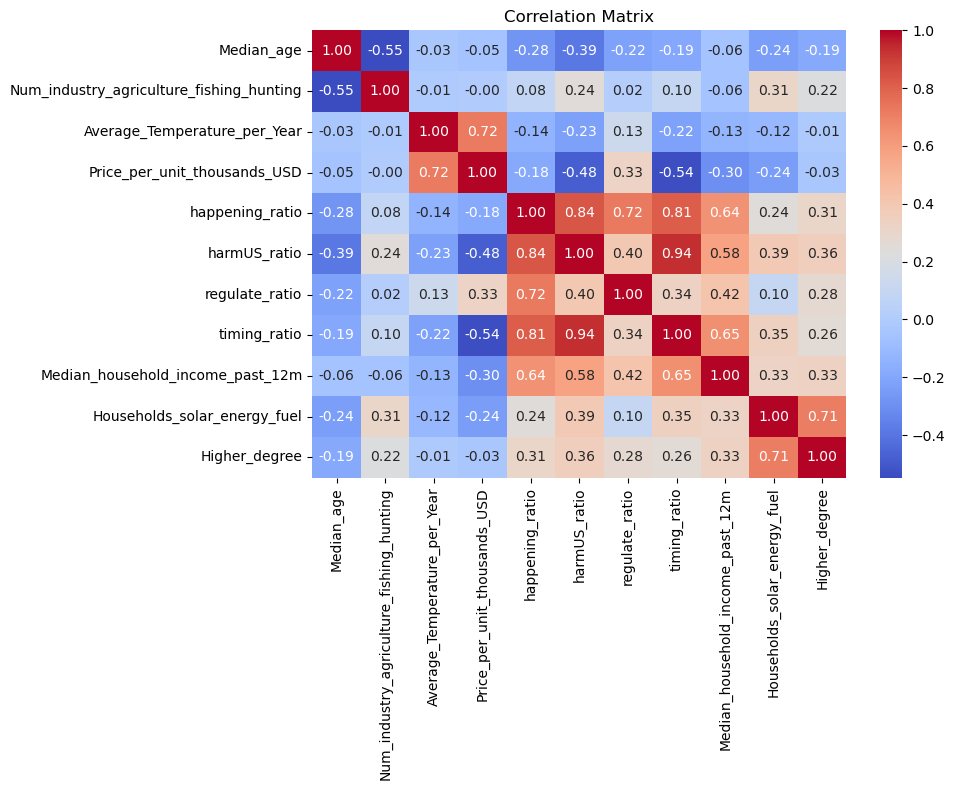

In [37]:
corr_matrix = df_X_scaled[features_to_use].corr()

plt.figure(figsize=(10, 8))  # Set the figure size

# Create a heatmap with colors and values
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show();

## setting up the final dataframe <a name="3.4"></a>

In [38]:
X_selected = df_X_scaled[features_to_use]

In [39]:
# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data['Variable'] = X_selected.columns
vif_data['VIF'] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]

# Print the VIF results
print(vif_data)

                                    Variable        VIF
0                                 Median_age   2.042454
1   Num_industry_agriculture_fishing_hunting   1.631931
2               Average_Temperature_per_Year   3.261353
3               Price_per_unit_thousands_USD   7.385138
4                            happening_ratio  11.659086
5                               harmUS_ratio  18.385153
6                             regulate_ratio   4.659533
7                               timing_ratio  17.580942
8           Median_household_income_past_12m   2.278090
9               Households_solar_energy_fuel   2.552280
10                             Higher_degree   2.546573


# initial modelling <a name="4"></a>

In [40]:
%%capture
np.random.seed(1509)

# Fit a linear regression model
model_reg = LinearRegression()
model_reg.fit(X_selected, df_y_scaled)
n_scenarios = 5000
n_years = 10  # want to generate scenarios for next 10 years

# Prepare a dataframe to hold your scenarios
scenario_df = pd.DataFrame(index=pd.date_range(start=X_selected.index.max() + pd.DateOffset(years=1),
                                               periods=n_years, freq='YS'))

# Dictionary to hold the independent variables' scenarios
ind_vars_scenarios = {var: pd.DataFrame(index=scenario_df.index) for var in X_selected.columns}

for i in range(n_scenarios):
    # Generate random fluctuations
    fluctuations = np.random.normal(loc=1, scale=0.05, size=(n_years, X_selected.shape[1]))
    
    # Generate scenario data
    scenario_data = model_reg.coef_ * fluctuations
    
    # Save independent variables' scenarios
    for j, var in enumerate(X_selected.columns):
        ind_vars_scenarios[var][f'scenario_{i}'] = scenario_data[:, j]
    
    residuals = df_y_scaled - model_reg.predict(X_selected)
    residual_std = np.std(residuals)

    # Predict target variable for the scenario
    y_pred_scaled = model_reg.predict(scenario_data)
    y_pred_scaled += np.random.normal(0, residual_std, size=y_pred_scaled.shape)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Unscale the predictions

    scenario_df[f'scenario_{i}'] = y_pred.reshape(-1)

In [41]:
# Transpose the dataframe 
scenario_df_T = scenario_df.T

### k-means clustering

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
 

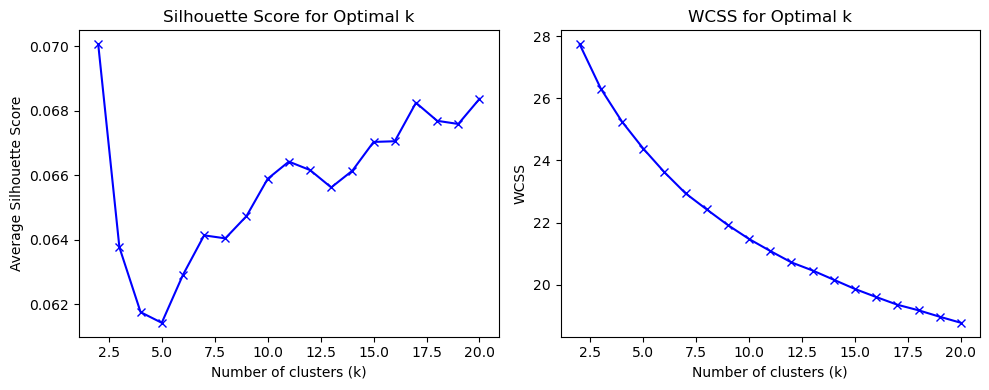

In [42]:
silhouette_elbow(scenario_df_T)

In [43]:
representative_scenarios_df = kmeans(scenario_df_T, scenario_df, 4)

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


In [44]:
representative_scenarios_df

,scenario_2169,scenario_4806,scenario_2240,scenario_682
2022-01-01,0.772671,0.763965,0.758289,0.780460
2023-01-01,0.758620,0.781288,0.775616,0.761756
2024-01-01,0.764756,0.777550,0.764492,0.768252
2025-01-01,0.781249,0.767148,0.760102,0.766181
2026-01-01,0.755180,0.759228,0.785691,0.774813
2027-01-01,0.773774,0.766188,0.775894,0.759116
2028-01-01,0.757140,0.773225,0.776331,0.768151
2029-01-01,0.761244,0.760703,0.759804,0.792038
2030-01-01,0.779839,0.773383,0.761572,0.762383
2031-01-01,0.756843,0.790543,0.758140,0.771989


### Visualizing scenario generator

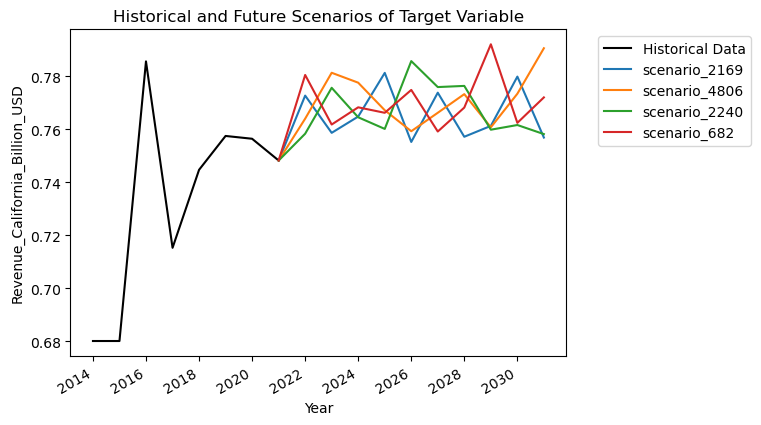

In [45]:
plot_historic_future_scenarios(representative_scenarios_df)

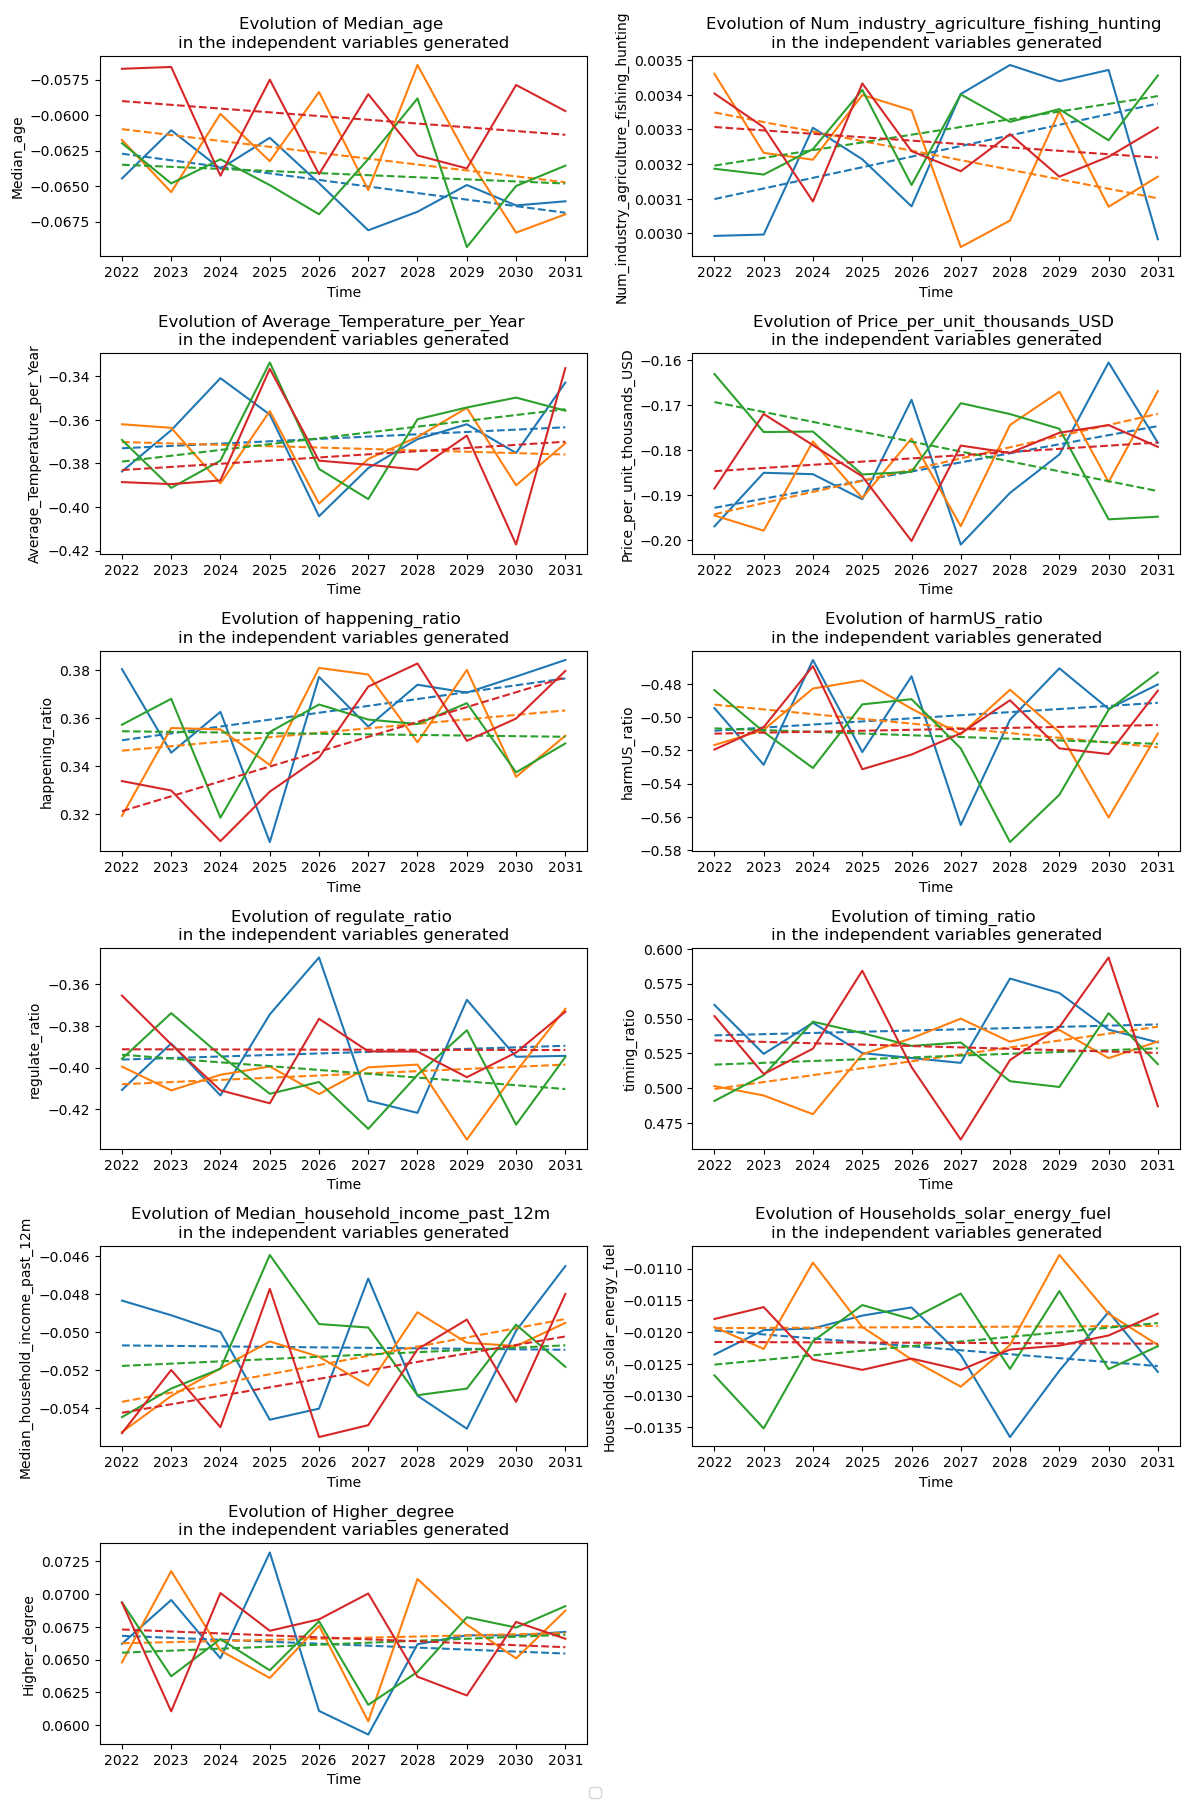

In [46]:
independent_var_generated(representative_scenarios_df, ind_vars_scenarios)

# Fine-tuning the models <a name="5"></a>

#### First we apply to the last 2 years to see how well the model performs compared to the actual data

Plan:

use monte carlo ismulation to generate scenarios based on the statistical properties and trends over time, followed by multiple regression. 

Then use K-means clustering to reduce the number of scenarios and select them based on the similartieiss

In [47]:
# checking the type of the index, making sure it is a datetime one
index_type = X_selected.index.inferred_type
print(index_type)

datetime64


#### Applying scenario generator to 2020 and 2021 to test the accuracy of the model

In [48]:
# Calculate date that is two years before the last date in the data
two_years_excl = X_selected.index.max() - pd.DateOffset(years=2)

# Exclude last two years from the data
X_selected_filtered = X_selected[X_selected.index <= two_years_excl]
df_y_scaled_filtered = df_y_scaled[df_y_scaled.index <= two_years_excl]

## Applying random fluctuations <a name="5.1"></a>

In [49]:
%%capture
np.random.seed(1509)

# Fit a linear regression model
model_reg_2y = LinearRegression()
model_reg_2y.fit(X_selected_filtered, df_y_scaled_filtered)

# Generate 5000 scenarios using MCS method
n_scenarios = 5000
n_years = 2  # Generate scenarios for last two years, i.2. 2020 and 2021

# Prepare a dataFrame to hold your scenarios (the target variable of the scenarios)
scenario_df_2y = pd.DataFrame(index=pd.date_range(start=X_selected_filtered.index.max() + pd.DateOffset(years=1),
                                               periods=n_years, freq='YS'))

# Dictionary to hold the independent variables' scenarios
ind_vars_scenarios_2y = {var: pd.DataFrame(index=scenario_df_2y.index) for var in X_selected_filtered.columns}
                              
for i in range(n_scenarios):
    # Generate random fluctuations with AR(1) process
    fluctuations = np.random.normal(loc=1, scale=0.05, size=(n_years, X_selected.shape[1]))
    
    # Generate scenario data
    scenario_data_2y = model_reg_2y.coef_ * fluctuations
    
    # Save independent variables' scenarios
    for j, var in enumerate(X_selected_filtered.columns):
        ind_vars_scenarios_2y[var][f'scenario_{i}'] = scenario_data_2y[:, j]
    
    residuals = df_y_scaled_filtered - model_reg_2y.predict(X_selected_filtered)
    residual_std = np.std(residuals)

    # Predict target variable for the scenario
    y_pred_scaled = model_reg_2y.predict(scenario_data_2y)
    y_pred_scaled += np.random.normal(0, residual_std, size=y_pred_scaled.shape)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Unscale the predictions

    scenario_df_2y[f'scenario_{i}'] = y_pred.reshape(-1)

In [50]:
scenario_df_T_2y = scenario_df_2y.T

In [51]:
representative_scenarios_df_2y = kmeans(scenario_df_T_2y,scenario_df_2y, 4)

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


In [52]:
representative_scenarios_df_2y

,scenario_4840,scenario_3220,scenario_664,scenario_3521
2020-01-01,0.856874,0.869720,0.816716,0.830137
2021-01-01,0.814452,0.855711,0.831278,0.871595


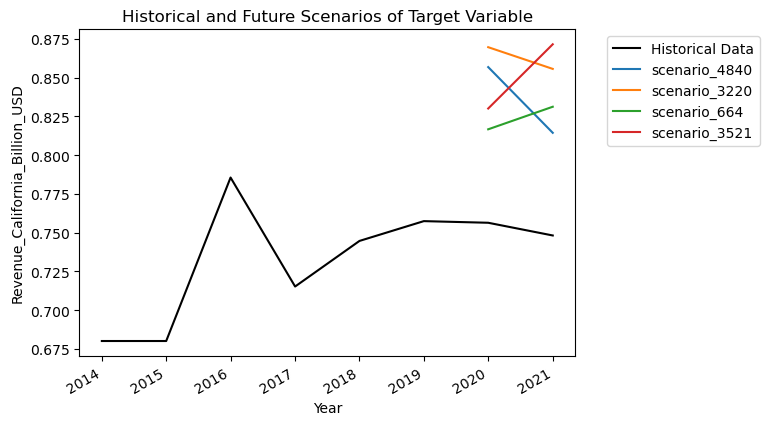

In [53]:
compare_actual_generated(representative_scenarios_df_2y)

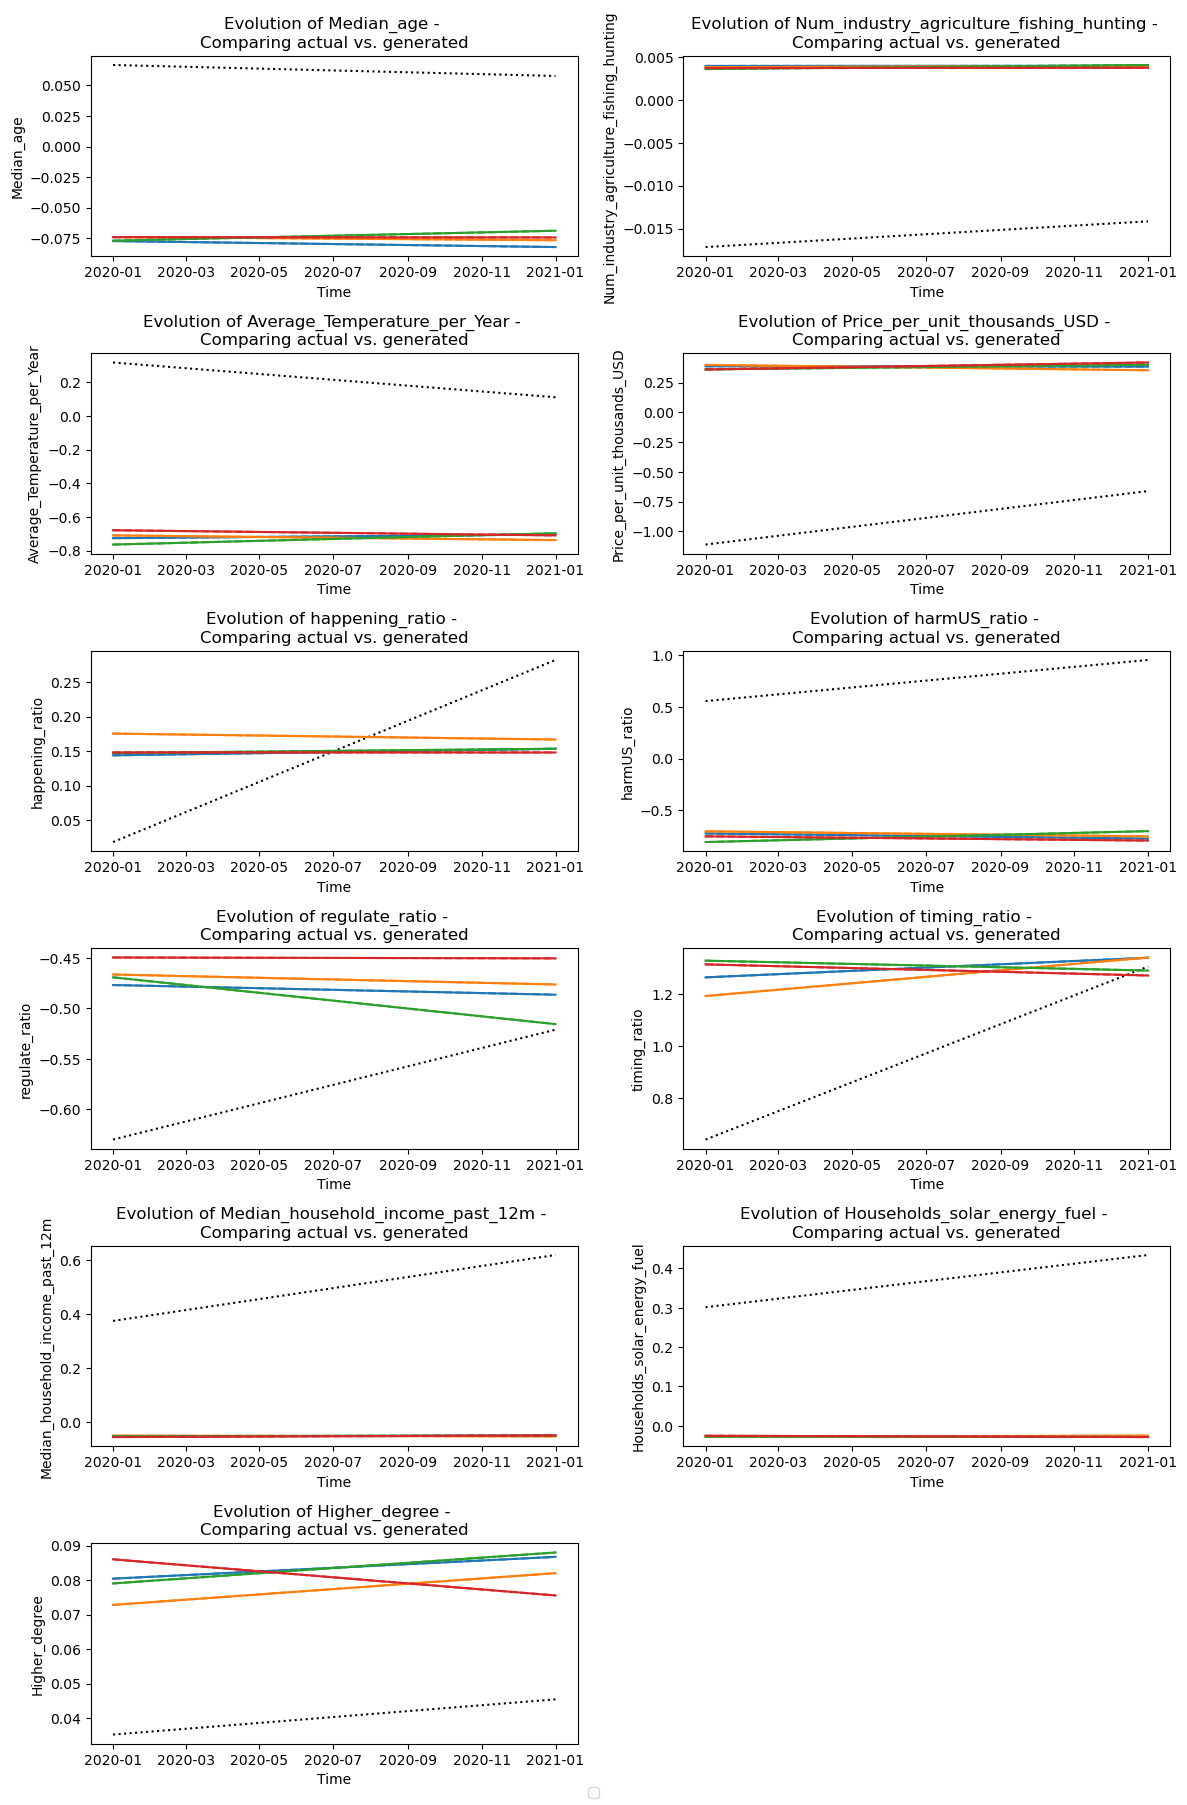

In [54]:
independent_var_comparison(representative_scenarios_df_2y, ind_vars_scenarios_2y)

In [55]:
# Calculate the mean of df_y for each year
df_y_mean = df_y.groupby(df_y.index.year).mean()
# Filter df_y_mean for the year 2020 and above
df_y_mean_2y = df_y_mean[df_y_mean.index >= 2020]

In [56]:
# Find the scenario with the mean closest to the actual values
best_scenario_id = (representative_scenarios_df_2y.mean() - df_y_mean_2y.mean()).abs().idxmin()

# Extract the best generated scenario for 2020 and 2021
best_scenario = representative_scenarios_df_2y[best_scenario_id].loc['2020':'2021']

# Perform a t-test to estimate the significance between the best scenario and the historical values
t_statistic, p_value = ttest_ind(best_scenario, df_y_mean_2y)

# Print the t-statistic and p-value
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 8.580535355264866
P-value: 0.013311637711123684


In [57]:
# Calculate mean absolute percentage error (MAPE)
mape = mean_absolute_percentage_error(df_y_mean_2y, best_scenario) * 100

# Calculate mean squared error (MSE)
mse = mean_squared_error(df_y_mean_2y, best_scenario)

# Print the results
print("MAPE:", mape)
print("MSE:", mse)

MAPE: 9.541099443416002
MSE: 0.005272217108579948


## Applying simple fluctuations <a name="5.2"></a>

### Monte Carlo Simulation combined with Multiple Regression

In [58]:
%%capture
np.random.seed(1509)

# Fit a linear regression model
model_reg_2y = LinearRegression()
model_reg_2y.fit(X_selected_filtered, df_y_scaled_filtered)

# Generate 5000 scenarios using MCS method
n_scenarios = 5000
n_years = 2  # Generate scenarios for last two years, i.2. 2020 and 2021

ar_process = ArmaProcess([1, -0.4], [1])

# Prepare a dataFrame to hold your scenarios (the target variable of the scenarios)
scenario_df_2y = pd.DataFrame(index=pd.date_range(start=X_selected_filtered.index.max() + pd.DateOffset(years=1),
                                               periods=n_years, freq='YS'))

# Dictionary to hold the independent variables' scenarios
ind_vars_scenarios_2y = {var: pd.DataFrame(index=scenario_df_2y.index) for var in X_selected_filtered.columns}
                              
for i in range(n_scenarios):
    # Generate random fluctuations with AR(1) process
    fluctuations = ar_process.generate_sample(nsample=(n_years, X_selected_filtered.shape[1]))
    
    # Generate scenario data
    scenario_data_2y = model_reg_2y.coef_ * fluctuations
    
    # Save independent variables' scenarios
    for j, var in enumerate(X_selected_filtered.columns):
        ind_vars_scenarios_2y[var][f'scenario_{i}'] = scenario_data_2y[:, j]
    residuals = df_y_scaled_filtered - model_reg_2y.predict(X_selected_filtered)
    residual_std = np.std(residuals)
    
    # Predict target variable for the scenario
    y_pred_scaled = model_reg_2y.predict(scenario_data_2y)
    y_pred_scaled += np.random.normal(0, residual_std, size=y_pred_scaled.shape)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    scenario_df_2y[f'scenario_{i}'] = y_pred.reshape(-1)

In [59]:
scenario_df_2y

,scenario_0,scenario_1,scenario_2,scenario_3,scenario_4,scenario_5,scenario_6,scenario_7,scenario_8,scenario_9,...,scenario_4990,scenario_4991,scenario_4992,scenario_4993,scenario_4994,scenario_4995,scenario_4996,scenario_4997,scenario_4998,scenario_4999
2020-01-01,0.748477,0.657273,0.732506,0.782394,0.573640,0.724690,0.686785,0.806870,0.713794,0.890059,...,0.836300,0.804392,0.846116,0.751399,0.692652,0.726844,0.618311,0.585007,0.695577,0.741722
2021-01-01,0.693307,0.655479,0.661878,0.735678,0.759385,0.764548,0.778101,0.752476,0.704143,0.802310,...,0.735954,0.587165,0.741920,0.683966,0.748173,0.728648,0.759459,0.686460,0.757919,0.882601


In [60]:
# Transpose the df
scenario_df_T_2y = scenario_df_2y.T

### k-means clustering scenario reduction

In [61]:
representative_scenarios_df_2y = kmeans(scenario_df_T_2y, scenario_df_2y, 4)

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


In [62]:
representative_scenarios_df_2y

,scenario_1192,scenario_4252,scenario_3006,scenario_1408
2020-01-01,0.661230,0.774443,0.803760,0.689852
2021-01-01,0.649104,0.696448,0.812201,0.769325


### Plotting results

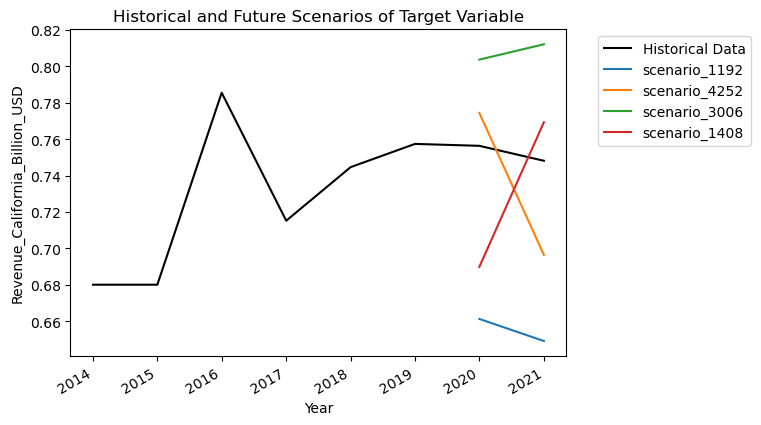

In [63]:
compare_actual_generated(representative_scenarios_df_2y)

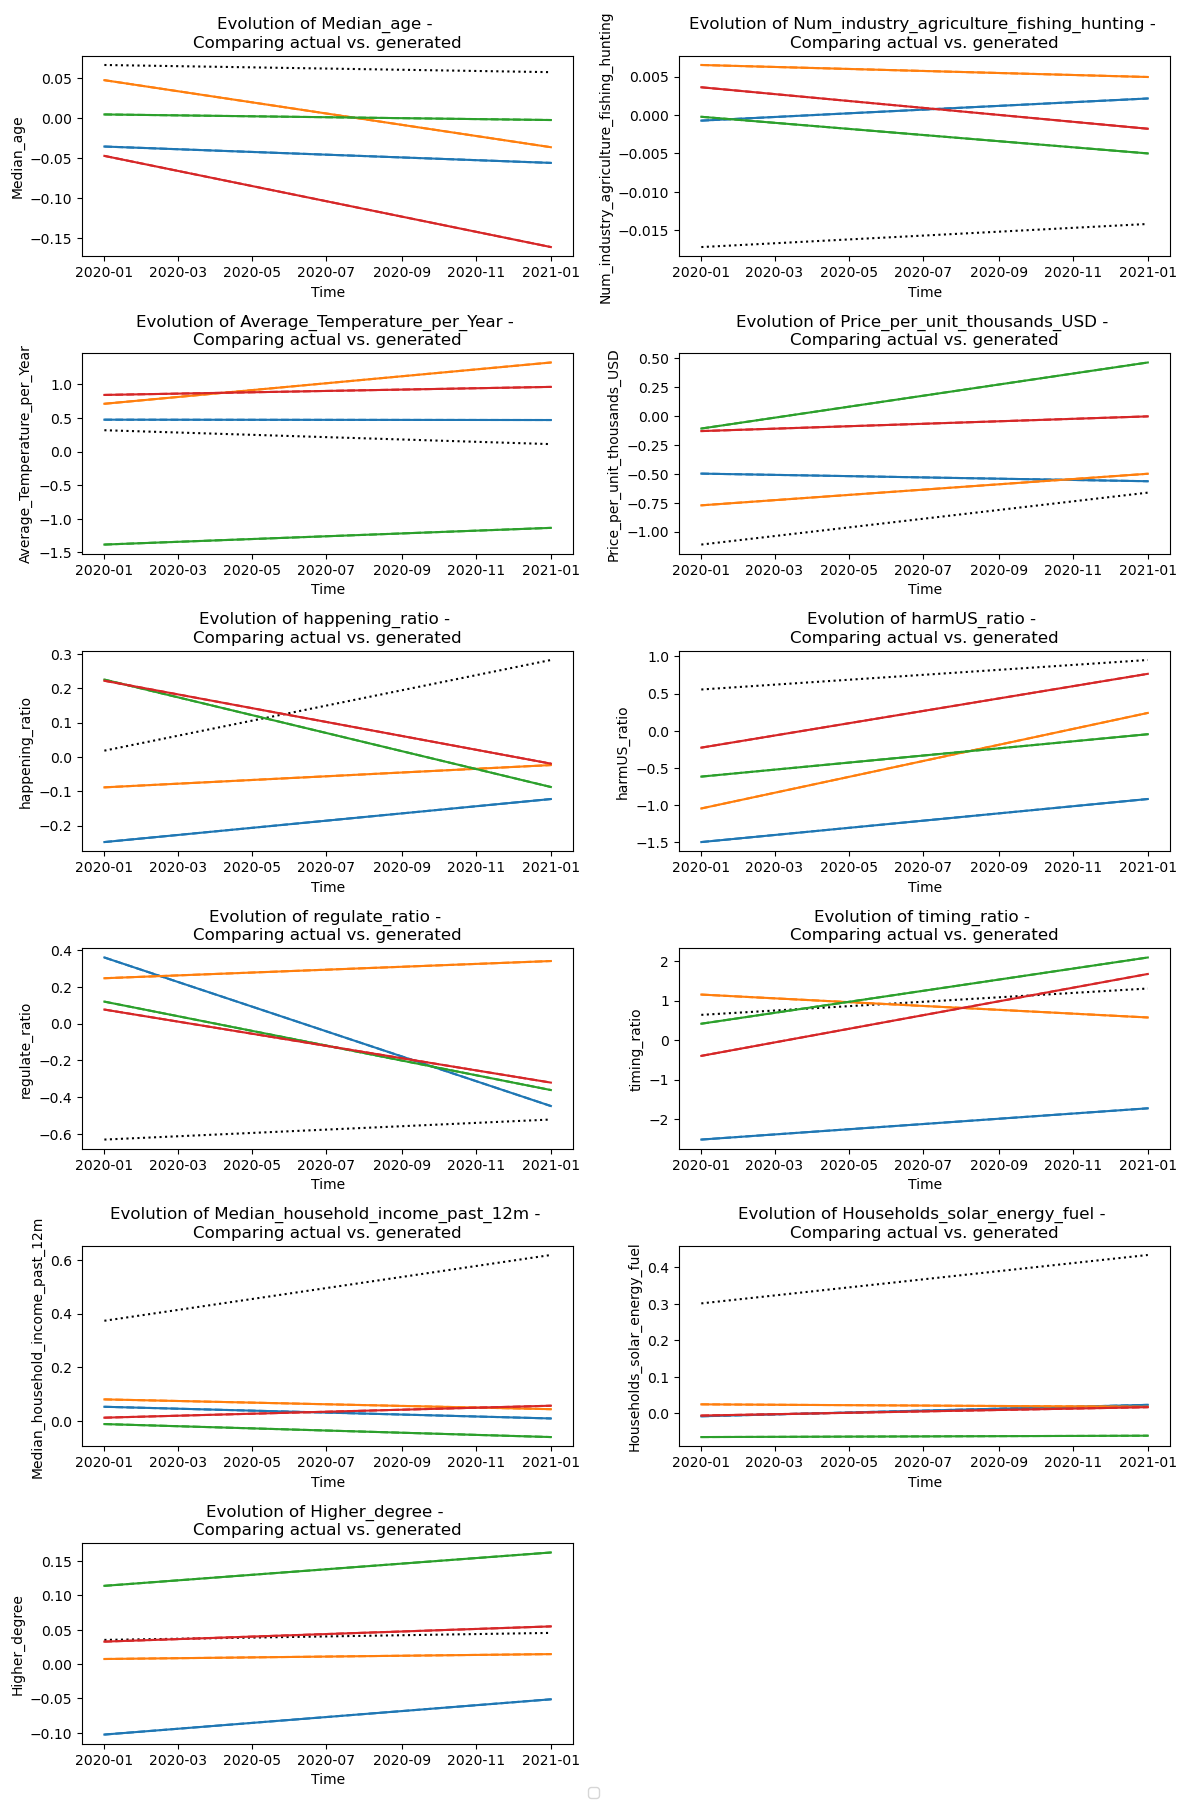

In [64]:
independent_var_comparison(representative_scenarios_df_2y, ind_vars_scenarios_2y)

### Evaluation metrics

In [65]:
# Find the scenario with the mean closest to the actual values
best_scenario_id = (representative_scenarios_df_2y.mean() - df_y_mean_2y.mean()).abs().idxmin()

# Extract the time series of the best scenario for 2020 and 2021
best_scenario = representative_scenarios_df_2y[best_scenario_id].loc['2020':'2021']

# Perform a t-test to estimate the significance between the best scenario and the historical values
t_statistic, p_value = ttest_ind(best_scenario, df_y_mean_2y)

# Print the t-statistic and p-value
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -0.429436049918338
P-value: 0.7094433012858329


In [66]:
# Calculate mean absolute percentage error (MAPE)
mape = mean_absolute_percentage_error(df_y_mean_2y, best_scenario) * 100

# Calculate mean squared error (MSE)
mse = mean_squared_error(df_y_mean_2y, best_scenario)

# Print the results
print("MAPE:", mape)
print("MSE:", mse)

MAPE: 4.65067102719795
MSE: 0.0015011101467561586


Null Hypothesis (H0): There is no significant difference between the best scenario and the historical values.

Alternative Hypothesis (Ha): There is a significant difference between the best scenario and the historical values.
    
P-value > 0.05 so we don't have enough evidence to reject null hypothesis 

need source but MAPE under 5% is very strong, between 5 and 25% is acceptable level

MSE, the closer to 0 the better

## Applying fluctuations with scale <a name="5.3"></a>

### Monte Carlo Simulation combined with Multiple Regression

In [67]:
%%capture
np.random.seed(1509)

# Fit a linear regression model
model_reg_2y = LinearRegression()
model_reg_2y.fit(X_selected_filtered, df_y_scaled_filtered)
n_scenarios = 5000
n_years = 2  # want to generate scenarios for next 2 years

ar_process = ArmaProcess([1, -0.4], [1])

# Prepare a DataFrame to hold your scenarios
scenario_df_2y = pd.DataFrame(index=pd.date_range(start=X_selected_filtered.index.max() + pd.DateOffset(years=1),
                                               periods=n_years, freq='YS'))

# Prepare a dictionary to hold the independent variables' scenarios
ind_vars_scenarios_2y = {var: pd.DataFrame(index=scenario_df_2y.index) for var in X_selected_filtered.columns}

for i in range(n_scenarios):
    # Generate random fluctuations with AR(1) process
    fluctuations = ar_process.generate_sample(nsample=(n_years, X_selected_filtered.shape[1]), scale=2.0)  # Increase scale to 2.0
    
    # Generate scenario data
    scenario_data_2y = model_reg_2y.coef_ * fluctuations
    
    # Save independent variables' scenarios
    for j, var in enumerate(X_selected_filtered.columns):
        ind_vars_scenarios_2y[var][f'scenario_{i}'] = scenario_data_2y[:, j]
    
    residuals = df_y_scaled_filtered - model_reg_2y.predict(X_selected_filtered)
    residual_std = np.std(residuals)

    # Predict target variable for the scenario
    y_pred_scaled = model_reg_2y.predict(scenario_data_2y)
    y_pred_scaled += np.random.normal(0, residual_std, size=y_pred_scaled.shape)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Unscale the predictions

    scenario_df_2y[f'scenario_{i}'] = y_pred.reshape(-1)

In [68]:
# Transpose the dataframe 
scenario_df_T_2y = scenario_df_2y.T

### k-means clustering

In [69]:
representative_scenarios_df_2y = kmeans(scenario_df_T_2y, scenario_df_2y, 4)

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


In [70]:
representative_scenarios_df_2y

,scenario_1843,scenario_3859,scenario_2574,scenario_423
2020-01-01,0.859200,0.605155,0.818076,0.644428
2021-01-01,0.896652,0.569057,0.683667,0.791966


### Plotting results

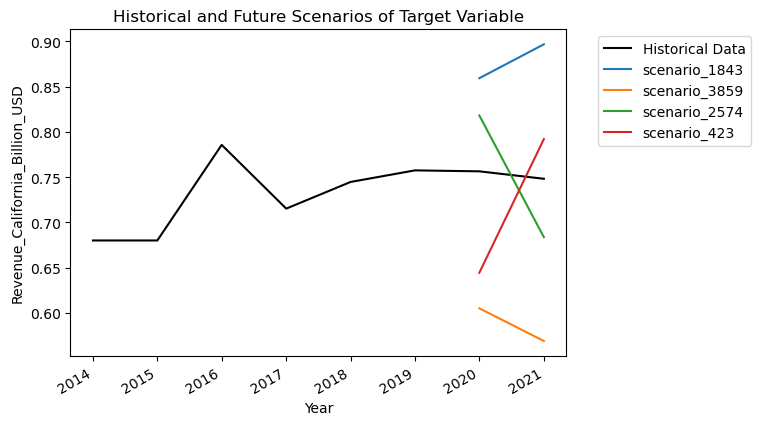

In [71]:
compare_actual_generated(representative_scenarios_df_2y)

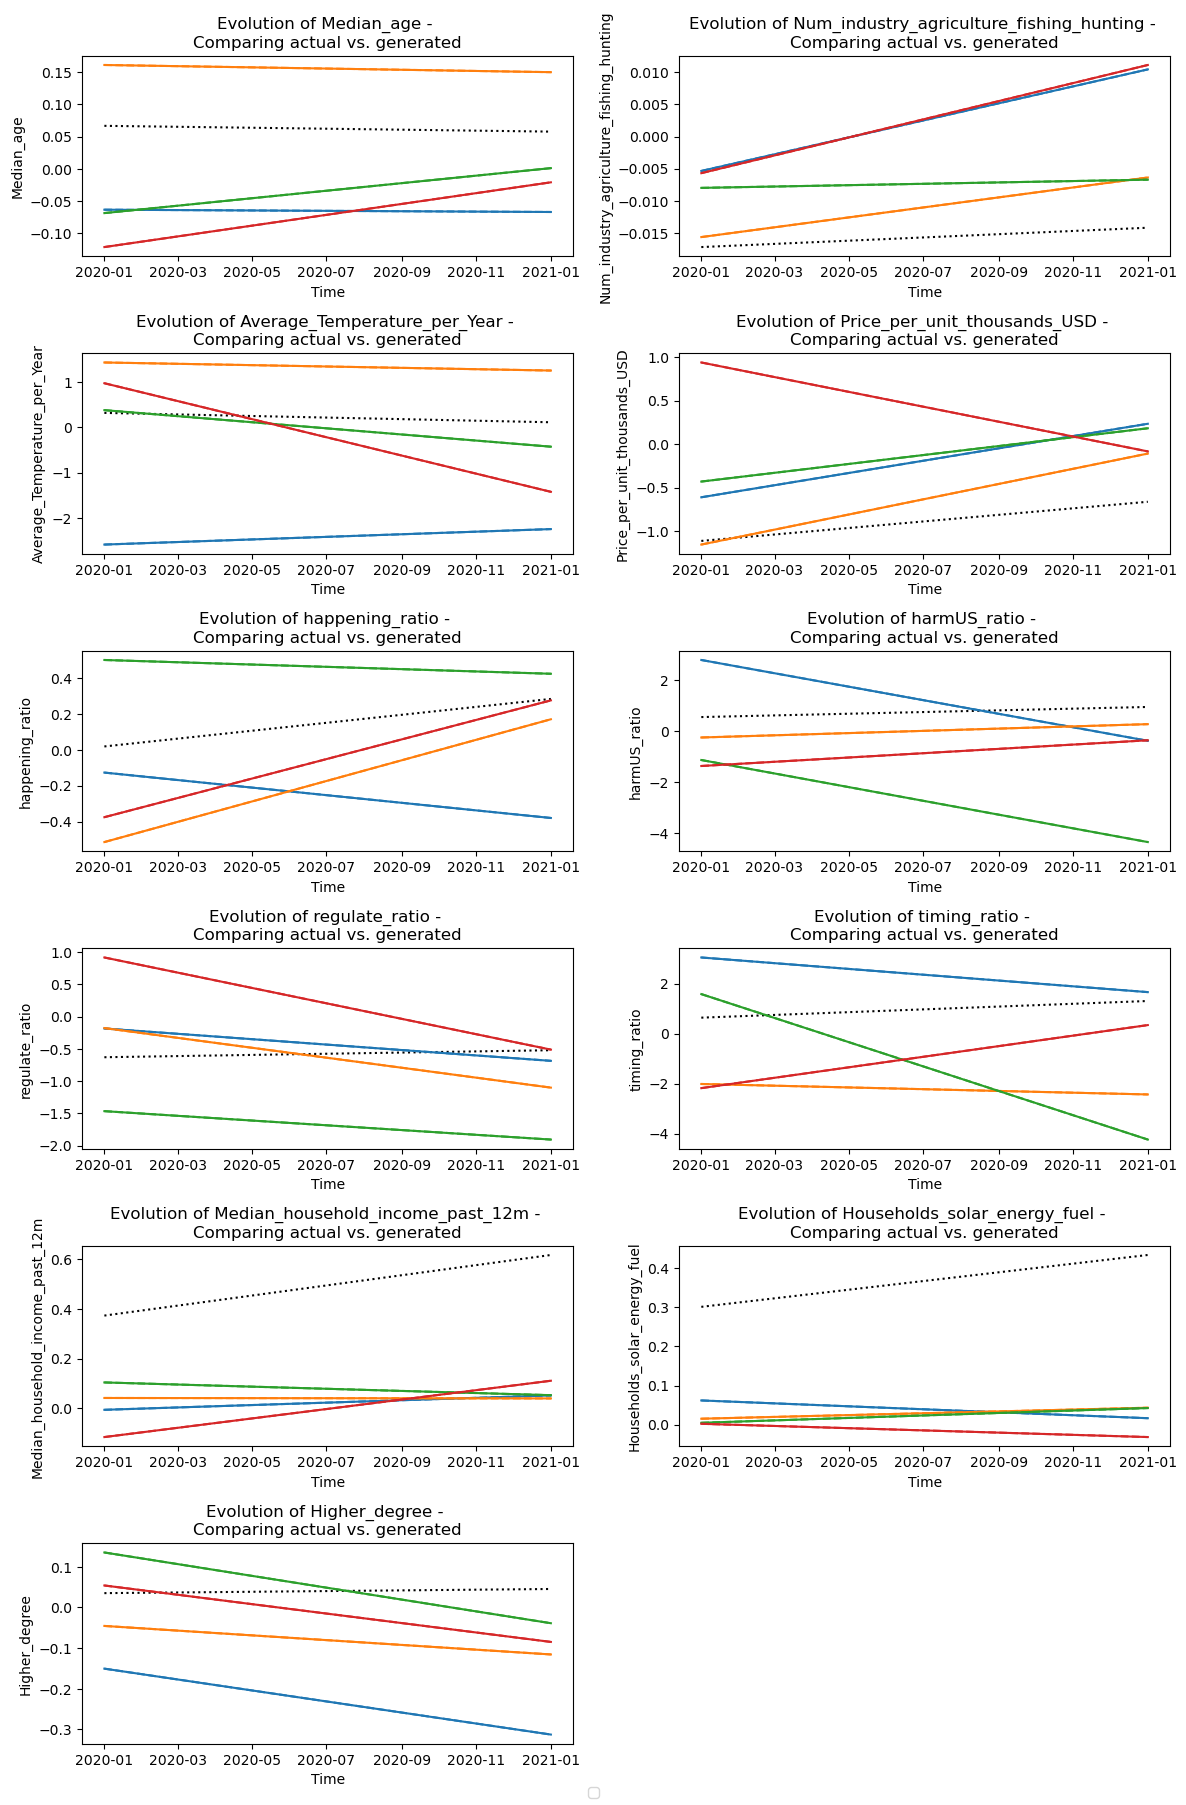

In [72]:
independent_var_comparison(representative_scenarios_df_2y, ind_vars_scenarios_2y)

### Evaluation metrics

In [73]:
# Find the scenario with the mean closest to the actual values
best_scenario_id = (representative_scenarios_df_2y.mean() - df_y_mean_2y.mean()).abs().idxmin()

# Extract the best scenario for 2020 and 2021
best_scenario = representative_scenarios_df_2y[best_scenario_id].loc['2020':'2021']

# Perform a t-test to estimate the significance between the best scenario and the historical values
t_statistic, p_value = ttest_ind(best_scenario, df_y_mean_2y)

# Print the t-statistic and p-value
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -0.02099235112064965
P-value: 0.9851578012400823


In [74]:
# Calculate mean absolute percentage error (MAPE)
mape = mean_absolute_percentage_error(df_y_mean_2y, best_scenario) * 100

# Calculate mean squared error (MSE)
mse = mean_squared_error(df_y_mean_2y, best_scenario)

# Print the results
print("MAPE:", mape)
print("MSE:", mse)

MAPE: 8.389143714742502
MSE: 0.003983692818053283


# Final model <a name="6"></a>

In [75]:
%%capture
np.random.seed(1509)

# Fit a linear regression model
model_reg = LinearRegression()
model_reg.fit(X_selected, df_y_scaled)
n_scenarios = 5000
n_years = 10  # Generate scenarios for next 10 years

ar_process = ArmaProcess([1, -0.4], [1])

# DataFrame to hold your scenarios
scenario_df = pd.DataFrame(index=pd.date_range(start=X_selected.index.max() + pd.DateOffset(years=1),
                                               periods=n_years, freq='YS'))

# Prepare a dictionary to hold the independent variables' scenarios
ind_vars_scenarios = {var: pd.DataFrame(index=scenario_df.index) for var in X_selected.columns}

# Get the last year's data
last_year_data_scaled = X_selected.iloc[-1, :]

for i in range(n_scenarios):

    # Generate random fluctuations with AR(1) process
    fluctuations = ar_process.generate_sample(nsample=(n_years, X_selected.shape[1]))
    
    # Generate scenario data
    scenario_data = model_reg.coef_ * fluctuations
    
    # Save independent variables' scenarios
    for j, var in enumerate(X_selected.columns):
        ind_vars_scenarios[var][f'scenario_{i}'] = scenario_data[:, j]
    
    residuals = df_y_scaled - model_reg.predict(X_selected)
    residual_std = np.std(residuals)

    # Predict target variable for the scenario
    y_pred_scaled = model_reg.predict(scenario_data)
    y_pred_scaled += np.random.normal(0, residual_std, size=y_pred_scaled.shape)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Unscale the predictions

    scenario_df[f'scenario_{i}'] = y_pred.reshape(-1)

In [76]:
# Transpose the dataframe such that scenarios are features and years are observations
scenario_df_T = scenario_df.T

### k-means clustering

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
 

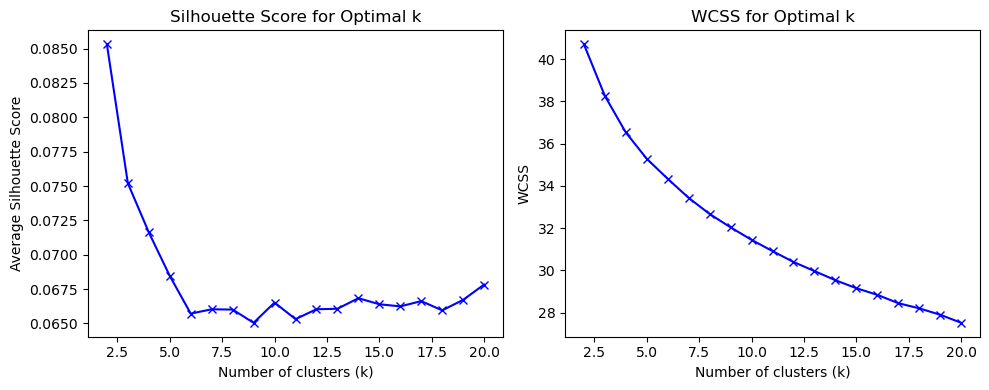

In [77]:
silhouette_elbow(scenario_df_T)

In [78]:
representative_scenarios_df = kmeans(scenario_df_T,scenario_df,4)

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


In [79]:
representative_scenarios_df

,scenario_4928,scenario_2335,scenario_1251,scenario_4687
2022-01-01,0.737576,0.722009,0.726068,0.748666
2023-01-01,0.744189,0.712249,0.729375,0.750900
2024-01-01,0.741158,0.712612,0.740179,0.740339
2025-01-01,0.738794,0.716978,0.747321,0.729149
2026-01-01,0.735188,0.716244,0.753182,0.726918
2027-01-01,0.727346,0.724041,0.752807,0.727080
2028-01-01,0.718020,0.728258,0.750950,0.736617
2029-01-01,0.709262,0.732113,0.746165,0.744435
2030-01-01,0.712517,0.734678,0.737412,0.751345
2031-01-01,0.722046,0.732709,0.727096,0.754415


### Visualizing scenario generator

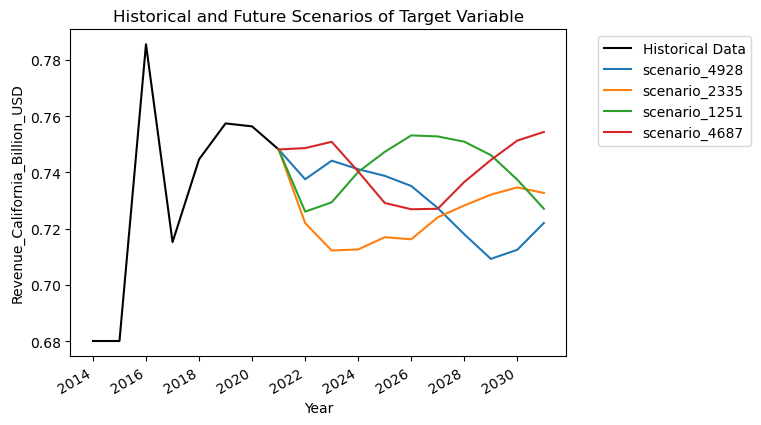

In [80]:
plot_historic_future_scenarios(representative_scenarios_df)

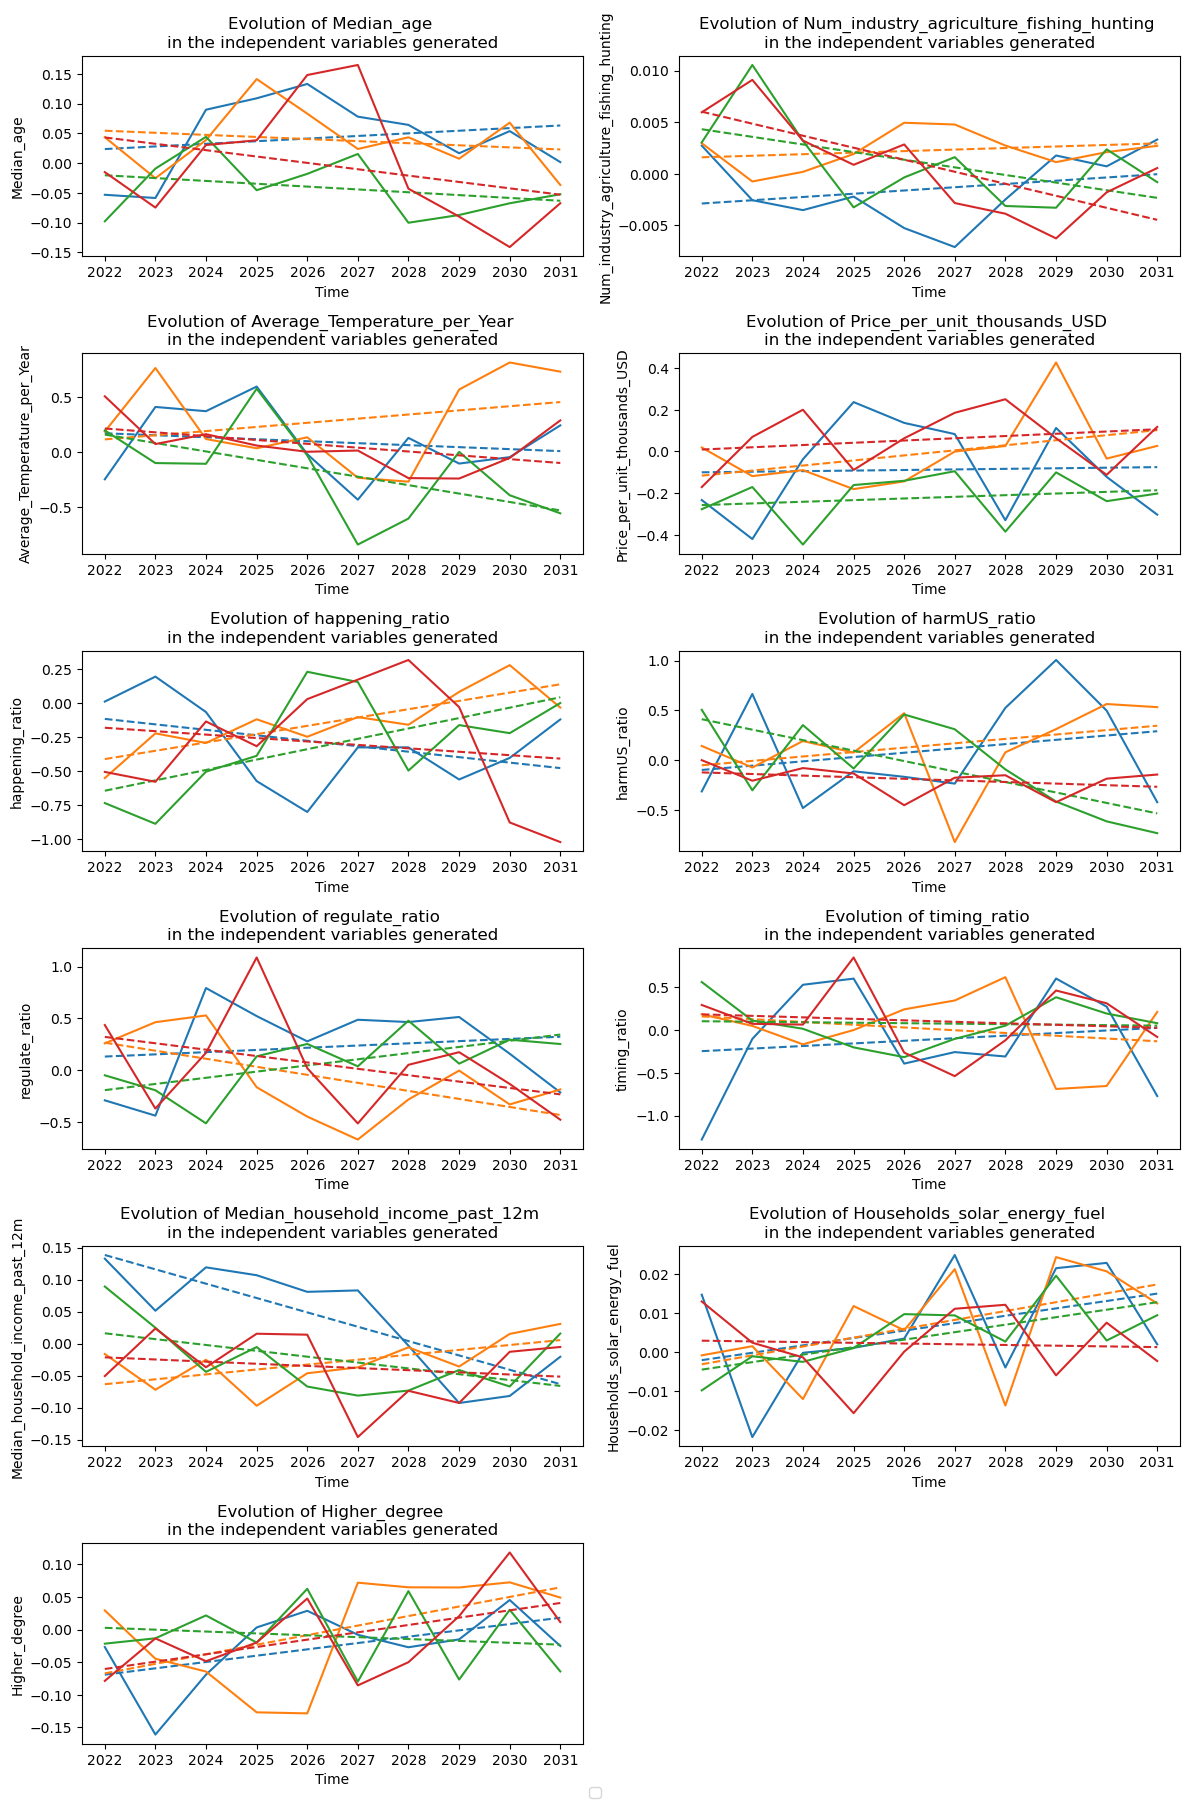

In [81]:
independent_var_generated(representative_scenarios_df, ind_vars_scenarios)

### Applying MAI

In [82]:
# Define weights
weights = {
    'Revenue_California_Billion_USD': 0.35,
    'Households_solar_energy_fuel': 0.08,
    'happening_ratio': 0.12,
    'harmUS_ratio': 0.06,
    'timing_ratio': 0.06,
    'Median_household_income_past_12m': 0.15,
    'Higher_degree': 0.12,
    'Num_industry_agriculture_fishing_hunting': 0.06,
}

In [83]:
# Prepare a DataFrame to hold the market attractiveness index for each scenario
market_attractiveness_df = pd.DataFrame(index=representative_scenarios_df.index, columns=representative_scenarios_df.columns)

for scenario in representative_scenarios_df.columns:
    # Get the target variable scenario (i.e., washing_machine_market_size)
    target_var_scenario = representative_scenarios_df[scenario]
    
    # Get the independent variables scenarios
    ind_vars_scenario = {var: ind_vars_scenarios[var][scenario] for var in weights.keys() if var != 'Revenue_California_Billion_USD'}
    
    # Calculate the market attractiveness index 
    market_attractiveness = target_var_scenario * weights['Revenue_California_Billion_USD'] + \
                            sum(ind_vars_scenario[var] * weights[var] for var in ind_vars_scenario.keys())
    
    market_attractiveness_df[scenario] = market_attractiveness

In [84]:
market_attractiveness_df

,scenario_4928,scenario_2335,scenario_1251,scenario_4687
2022-01-01,0.181903,0.207318,0.240044,0.203186
2023-01-01,0.304279,0.205016,0.139694,0.187908
2024-01-01,0.263874,0.203333,0.216521,0.230770
2025-01-01,0.235424,0.212588,0.194521,0.258828
2026-01-01,0.142983,0.242305,0.298223,0.223032
2027-01-01,0.198931,0.217577,0.273839,0.200998
2028-01-01,0.221029,0.283729,0.196794,0.263504
2029-01-01,0.263504,0.248065,0.225873,0.247283
2030-01-01,0.242362,0.298252,0.200256,0.177828
2031-01-01,0.160921,0.309071,0.210794,0.128041


### Estimating filters' market size

In [85]:
avg_price_filters = 130

In [86]:
# Prepare two DataFrames to hold the estimated filters market size for each scenario with and without regulation
filters_market_size_df_no_regulation = pd.DataFrame(index=representative_scenarios_df.index, columns=[f"{col}_no_regulation" for col in market_attractiveness_df.columns])
filters_market_size_df_with_regulation = pd.DataFrame(index=representative_scenarios_df.index, columns=[f"{col}_with_regulation" for col in market_attractiveness_df.columns])

# Extract mean and standard deviation of 'Price_per_unit_thousands_USD' before scaling to unscale
price_mean = scaler_X.mean_[df_X.columns.get_loc('Price_per_unit_thousands_USD')]
price_std = scaler_X.scale_[df_X.columns.get_loc('Price_per_unit_thousands_USD')]

for scenario in market_attractiveness_df.columns:
    # Calculate the market size for the microplastic filters for the scenario without regulation
    scaled_price = ind_vars_scenarios['Price_per_unit_thousands_USD'][scenario]
    washing_machine_price = (scaled_price * price_std + price_mean) * 1000  # Convert the price from thousands to single unit

    market_attractiveness = market_attractiveness_df[scenario]
    washing_machine_market_size = representative_scenarios_df[scenario] * 1_000_000_000  # convert from billions to single unit

    filters_market_size_no_regulation = market_attractiveness * washing_machine_market_size * (avg_price_filters / washing_machine_price)
    filters_market_size_no_regulation = filters_market_size_no_regulation.clip(lower=0)  # ensure market size is not negative
    filters_market_size_df_no_regulation[f"{scenario}_no_regulation"] = filters_market_size_no_regulation

    # Calculate the market size for the microplastic filters for the scenario with regulation
    filters_market_size_with_regulation = filters_market_size_no_regulation.copy()
    filters_market_size_with_regulation[filters_market_size_with_regulation.index.year >= 2029] = washing_machine_market_size[filters_market_size_with_regulation.index.year >= 2029] * (avg_price_filters / washing_machine_price)
    filters_market_size_df_with_regulation[f"{scenario}_with_regulation"] = filters_market_size_with_regulation


### Visualizing filters' market size

In [87]:
# Save original setting
orig_format = pd.options.display.float_format

# Set new format
pd.options.display.float_format = '{:,.0f}'.format

# Display the tables
filters_market_size_df_no_regulation
filters_market_size_df_with_regulation

# Reset to original format
pd.options.display.float_format = orig_format

,scenario_4928_no_regulation,scenario_2335_no_regulation,scenario_1251_no_regulation,scenario_4687_no_regulation
2022-01-01,"35,848,198","39,539,294","46,661,567","40,529,381"
2023-01-01,"61,023,872","38,812,658","27,146,444","37,186,665"
2024-01-01,"51,792,413","38,463,171","43,242,494","44,763,745"
2025-01-01,"45,496,563","40,628,132","38,714,011","50,094,705"
2026-01-01,"27,620,210","46,182,000","59,762,877","42,740,464"
2027-01-01,"38,109,904","41,649,500","54,735,222","38,315,616"
2028-01-01,"42,591,875","54,563,369","39,761,405","50,741,974"
2029-01-01,"49,159,910","47,105,916","44,760,403","48,529,211"
2030-01-01,"45,907,613","58,019,622","39,465,919","35,503,344"
2031-01-01,"31,145,065","59,798,710","40,893,355","25,402,598"


,scenario_4928_with_regulation,scenario_2335_with_regulation,scenario_1251_with_regulation,scenario_4687_with_regulation
2022-01-01,"35,848,198","39,539,294","46,661,567","40,529,381"
2023-01-01,"61,023,872","38,812,658","27,146,444","37,186,665"
2024-01-01,"51,792,413","38,463,171","43,242,494","44,763,745"
2025-01-01,"45,496,563","40,628,132","38,714,011","50,094,705"
2026-01-01,"27,620,210","46,182,000","59,762,877","42,740,464"
2027-01-01,"38,109,904","41,649,500","54,735,222","38,315,616"
2028-01-01,"42,591,875","54,563,369","39,761,405","50,741,974"
2029-01-01,"186,562,088","189,893,667","198,166,541","196,249,733"
2030-01-01,"189,417,359","194,532,394","197,077,322","199,649,744"
2031-01-01,"193,542,014","193,479,082","193,996,710","198,393,953"


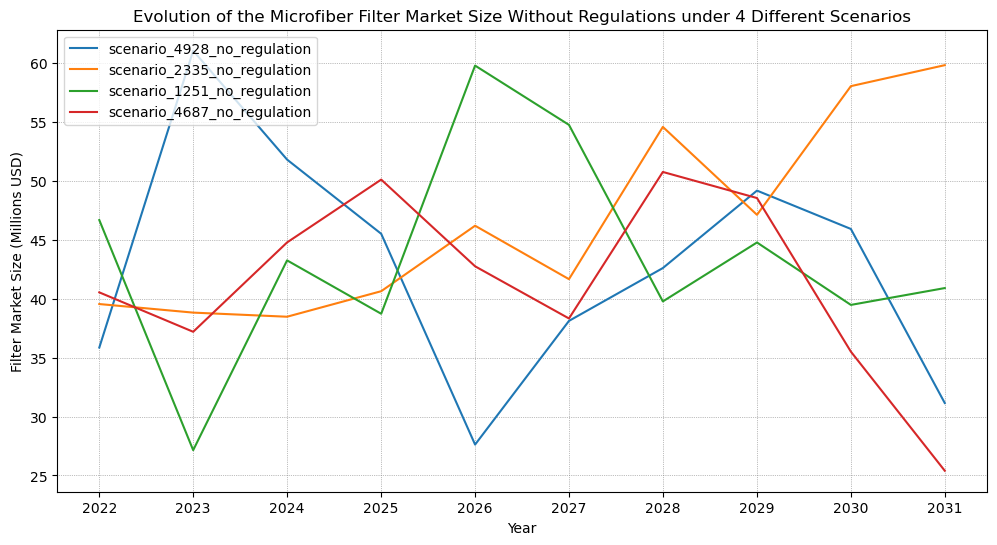

In [88]:
# Convert data to millions
filters_market_size_df_no_regulation_mil = filters_market_size_df_no_regulation / 1000000

plt.figure(figsize=(12, 6))
# Add thin grey dotted lines in the background
plt.grid(linestyle='dotted', linewidth=0.5, color='grey')

for column in filters_market_size_df_no_regulation_mil.columns:
    plt.plot(filters_market_size_df_no_regulation_mil.index, filters_market_size_df_no_regulation_mil[column], label=column)

plt.xlabel('Year')
plt.ylabel('Filter Market Size (Millions USD)')
plt.title('Evolution of the Microfiber Filter Market Size Without Regulations under 4 Different Scenarios')
plt.legend()
plt.show();

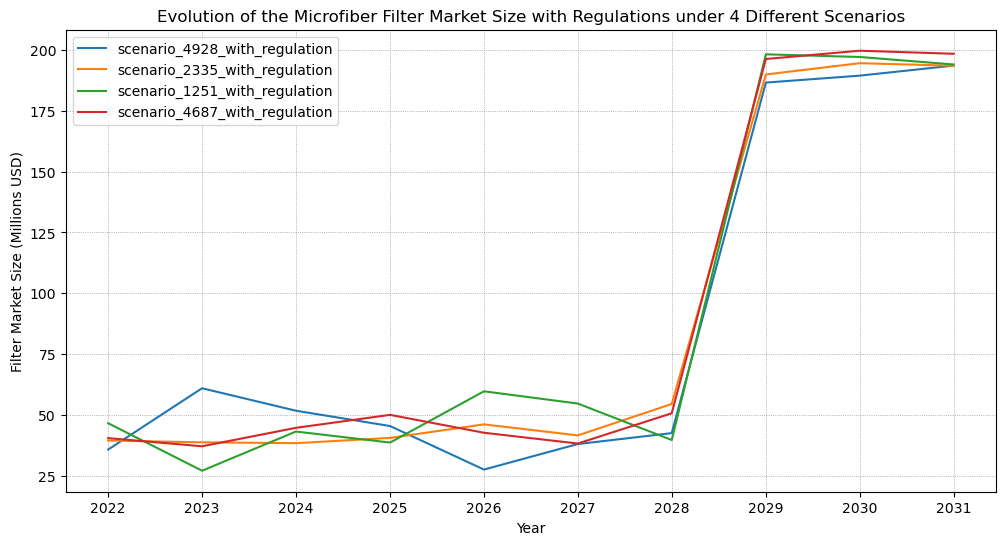

In [89]:
# Convert data to millions
filters_market_size_df_with_regulation_mil = filters_market_size_df_with_regulation / 1000000

plt.figure(figsize=(12, 6))
# Add thin grey dotted lines in the background
plt.grid(linestyle='dotted', linewidth=0.5, color='grey')

for column in filters_market_size_df_with_regulation_mil.columns:
    plt.plot(filters_market_size_df_with_regulation_mil.index, filters_market_size_df_with_regulation_mil[column], label=column)

plt.xlabel('Year')
plt.ylabel('Filter Market Size (Millions USD)')
plt.title('Evolution of the Microfiber Filter Market Size with Regulations under 4 Different Scenarios')
plt.legend()
plt.show();

## Sensitivity analysis <a name="7"></a>

In [90]:
# Create a DataFrame of coefficients
coef_df = pd.DataFrame(model_reg.coef_.reshape(-1, 1), index=X_selected.columns, columns=['Coefficient'])

# Calculate the absolute value of the coefficients to see their impact regardless of direction
coef_df['Absolute_Coefficient'] = abs(coef_df['Coefficient'])

# Sort by the absolute value of the coefficient
coef_df = coef_df.sort_values('Absolute_Coefficient', ascending=False)

print(coef_df)

                                          Coefficient  Absolute_Coefficient
timing_ratio                                 0.524819              0.524819
harmUS_ratio                                -0.504144              0.504144
regulate_ratio                              -0.396508              0.396508
Average_Temperature_per_Year                -0.369545              0.369545
happening_ratio                              0.352365              0.352365
Price_per_unit_thousands_USD                -0.183360              0.183360
Higher_degree                                0.065426              0.065426
Median_age                                  -0.063736              0.063736
Median_household_income_past_12m            -0.052313              0.052313
Households_solar_energy_fuel                -0.012239              0.012239
Num_industry_agriculture_fishing_hunting     0.003235              0.003235


In [91]:
selected_sensitivity = ['Median_age','happening_ratio','harmUS_ratio','regulate_ratio','timing_ratio','Median_household_income_past_12m','Households_solar_energy_fuel','Higher_degree']

In [92]:
%%capture
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
filters_market_size_df_no_regulation_scaled = pd.DataFrame(
    scaler.fit_transform(filters_market_size_df_no_regulation),
    index=filters_market_size_df_no_regulation.index,
    columns=filters_market_size_df_no_regulation.columns)

# Initialize a dictionary to store the sensitivity results
sensitivity_results = {}

# Perform the sensitivity analysis for each independent variable
for var in selected_sensitivity:
    if var in ind_vars_scenarios:
        scenario_market = ind_vars_scenarios[var]
        # Initialize a list to store the sensitivity values for each scenario
        sensitivity_values = []

        # Iterate over each scenario in filters_market_size_df_no_regulation.columns
        for scenario in filters_market_size_df_no_regulation_scaled.columns:
            scenario_no_regulation = scenario.replace("_no_regulation", "")
            market_size_scenario_no_regulation = filters_market_size_df_no_regulation_scaled[scenario]

            if scenario_no_regulation in scenario_market.columns:
                # Get the corresponding independent variable scenario
                independent_variable_scenario = scenario_market[scenario_no_regulation]

                X = independent_variable_scenario.values.reshape(-1, 1)
                y = market_size_scenario_no_regulation.values.reshape(-1, 1)

                # Fit the regression model
                model = LinearRegression()
                model.fit(X, y)

                # Get the coefficient (sensitivity) of the independent variable
                sensitivity = model.coef_[0][0]

                sensitivity_values.append(sensitivity)

        sensitivity_results[var] = sensitivity_values

In [93]:
sensitivity_results

{'Median_age': [-4.84896576221287,
  -3.854287866311738,
  3.2784830452942773,
  1.955987707732529],
 'happening_ratio': [1.487232076766325,
  3.045995771697148,
  2.116239743451551,
  1.7651721428049325],
 'harmUS_ratio': [1.0952977394656565,
  1.3982382046839426,
  1.3960068552246367,
  -1.2757480217168435],
 'regulate_ratio': [0.14242433117349457,
  -1.2813448360055513,
  0.5724862171666034,
  1.5114164314527407],
 'timing_ratio': [1.0245856991892428,
  -0.18140161125098372,
  -1.162170845836589,
  0.9657702370877395],
 'Median_household_income_past_12m': [-1.506534629803561,
  20.972780817369756,
  -7.029937483511126,
  -3.8632928963686597],
 'Households_solar_energy_fuel': [-26.76331195150033,
  17.94201908535395,
  43.31499106414674,
  -24.167907212620968],
 'Higher_degree': [-12.099861876982809,
  6.638654698398045,
  0.4182471806995955,
  -4.224839156406368]}

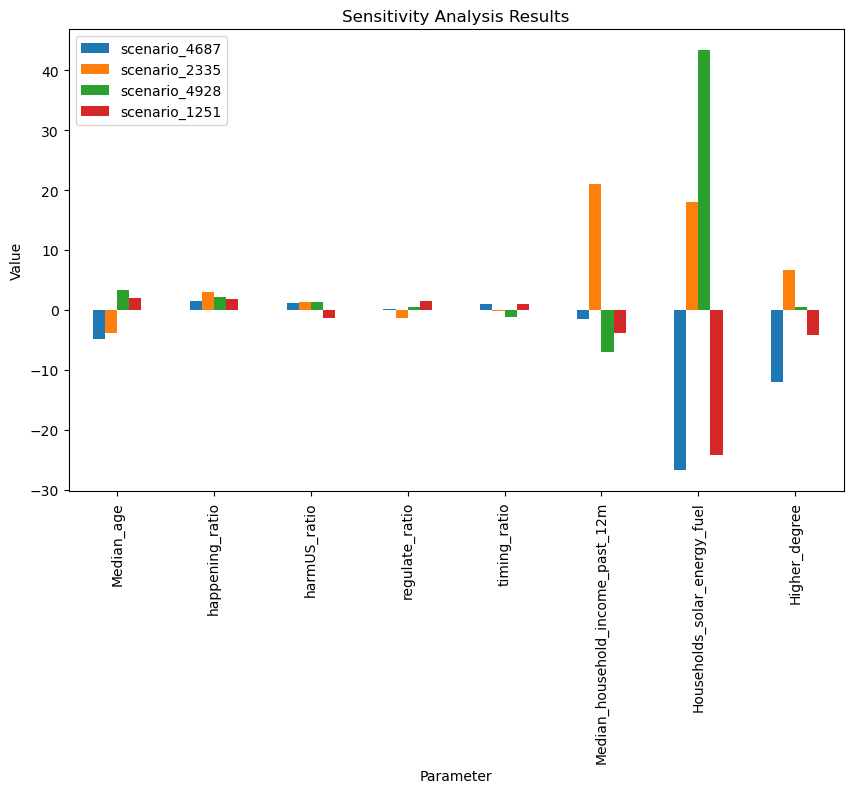

In [94]:
# Convert the dictionary to a DataFrame
df_sensitivity = pd.DataFrame(sensitivity_results).T
df_sensitivity.columns = ['scenario_4687', 'scenario_2335', 'scenario_4928', 'scenario_1251']

# Plot
df_sensitivity.plot(kind='bar', figsize=(10, 6))
plt.title("Sensitivity Analysis Results")
plt.xlabel("Parameter")
plt.ylabel("Value")
plt.xticks(rotation=90)  # rotate x labels for better visibility
plt.legend(['scenario_4687', 'scenario_2335', 'scenario_4928', 'scenario_1251'], loc='upper left')
plt.show();


In [95]:
df_sensitivity

,scenario_4687,scenario_2335,scenario_4928,scenario_1251
Median_age,-4.848966,-3.854288,3.278483,1.955988
happening_ratio,1.487232,3.045996,2.116240,1.765172
harmUS_ratio,1.095298,1.398238,1.396007,-1.275748
regulate_ratio,0.142424,-1.281345,0.572486,1.511416
timing_ratio,1.024586,-0.181402,-1.162171,0.965770
Median_household_income_past_12m,-1.506535,20.972781,-7.029937,-3.863293
Households_solar_energy_fuel,-26.763312,17.942019,43.314991,-24.167907
Higher_degree,-12.099862,6.638655,0.418247,-4.224839
